## Tutorial for using TF.Data, Keras, Estimator, and Google storage

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Make sure you have TF >= 1.11

Please install tf-nightly-gpu by ```pip install --upgrade tf-nightly``` if you have TF < 1.11

In [2]:
from tensorflow import keras
import tensorflow as tf
print(tf.__version__)

1.13.0a-dev20181218


## 0. Using Keras with numpy arrays

**Load image data from MNIST**

In [ ]:
(x_train, y_train),(x_test, y_test) = keras.datasets.mnist.load_data()
print('X shape:',x_train.shape, 'y shape:',y_train.shape)

Great, so it appears that we have 60,000 samples in our training set, and the images are 28 pixels x 28 pixels each. We can confirm this by plotting the first sample in matplotlib:

In [ ]:
plt.imshow(x_train[0])

**Preprocess input data for Keras**

We convert the input data to (60000, 28, 28, 1), float32 and normalize our data values to the range [0, 1].

In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [ ]:
print(x_train.shape)

**Preprocess class labels for Keras**

Y are usually prepared in int32

In [ ]:
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

Let's take a look at the labels for the first 10 training samples:

In [ ]:
print(y_train[:10])

The y_train and y_test data are not split into 10 distinct class labels, but rather are represented as a single array with the class values. We can fix this easily:

In [ ]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [ ]:
print(y_train.shape)

**Define model architecture**

In [3]:
from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten # Keras core layes
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D # Keras CNN layers

In [4]:
def myModel(inputShape, nClasses):
    # Model input
    inputs = Input(shape=inputShape)
     
    # Convolutional layers    
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    
    # Fully connected Dense layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(nClasses, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='myModel')
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
        
    return model  

In [ ]:
print('Input shape:',x_train.shape[1:])

In [ ]:
model = myModel(inputShape = x_train.shape[1:], nClasses = 10)
print('Output shape:', model.output_shape)

In [ ]:
model.summary()

**Train model**

In [ ]:
# Fit Keras model
model.fit(x_train, y_train, batch_size=16, epochs=1, validation_data=(x_test, y_test))

**Prediction**

In [ ]:
y_out = model.predict(x_test, batch_size=16)

In [ ]:
print(y_test[0,:])

In [ ]:
print(y_out[0,:])

In [ ]:
del model
keras.backend.clear_session()

## 1. Using Keras with numpy arrays from HDF5 files

## 2. Using Keras with tf.data from numpy arrays on the memory

**Load MNIST data**

In [ ]:
(x_train, y_train),(x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

X and Y are usually prepared in float32 & int32

In [ ]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [ ]:
nClasses = 10
input_shape = (x_train.shape[1], x_train.shape[2])

### Creating tf.data.Dataset

**Parse function for data preprocessing**

Prepare train and test datasets using tf.data:
- Preprocess input data: float32 and normalize to the range [0, 1]
- Preprocess output data: convert 1-dimensional class arrays to 10-dimensional class matrices

In [ ]:
def parse_function(xx, yy):
    xx = tf.divide(xx, 255.0)
    xx = tf.reshape(xx, [input_shape[0], input_shape[1], 1])
    yy = tf.one_hot(yy, nClasses)
    return xx, yy

**Creating `tf.data.Dataset` from numpy arrays**

The function starts by using the `tf.data.Dataset.from_tensor_slices` function to create a `tf.data.Dataset` representing slices of the array. The array is sliced across the first dimension. For example, an array containing the MNIST training data has a shape of *(60000, 28, 28)*. Passing this to from_tensor_slices returns a Dataset object containing *60000* slices, each one a *28x28* image.

In [ ]:
def create_dataset(x_data, y_data, shuffleSize, batchSize):
    
    # This works with arrays as well
    dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    
    # Maps the preprocessing function. You can set the number of parallel loaders here
    dataset = dataset.map(parse_function, num_parallel_calls=8)
    
    # This dataset will go on forever
    dataset = dataset.repeat()
    
    # Set the number of datapoints you want to load and shuffle 
    dataset = dataset.shuffle(shuffleSize)
    
    # Set the batchsize
    dataset = dataset.batch(batchSize)
    
    # Create an iterator
    iterator = dataset.make_one_shot_iterator()
    
    return iterator

In [ ]:
batchSize=16
data_train = create_dataset(x_train, y_train, shuffleSize=60000, batchSize=batchSize)
data_test = create_dataset(x_test, y_test, shuffleSize=10000, batchSize=batchSize)

Number of steps for training & testing each epoch

In [ ]:
nEpoch = 1
nStep_train = (int)(x_train.shape[0]/batchSize)
nStep_test = (int)(x_test.shape[0]/batchSize)

In [ ]:
model = myModel(inputShape = (input_shape[0], input_shape[1], 1), nClasses = 10)

**Train model**

In [ ]:
model.fit(data_train, epochs=nEpoch, validation_data=data_test, steps_per_epoch=nStep_train, validation_steps=nStep_test)

**Prediction**

In [ ]:
def parse_function(xx):
    xx = tf.divide(xx, 255.0)
    xx = tf.reshape(xx, [input_shape[0], input_shape[1], 1])
    return xx

In [ ]:
def create_dataset_val(x_data, batchSize):
    
    # This works with arrays as well
    dataset = tf.data.Dataset.from_tensor_slices(x_data)
    
    # Maps the preprocessing function. You can set the number of parallel loaders here
    dataset = dataset.map(parse_function, num_parallel_calls=8)
    
    # This dataset will go on forever
    dataset = dataset.repeat()
    
    # Set the batchsize
    dataset = dataset.batch(batchSize)
    
    # Create an iterator
    iterator = dataset.make_one_shot_iterator()
    
    return iterator

In [ ]:
batchSize=16
data_val = create_dataset_val(x_test, batchSize)

In [ ]:
y_out = model.predict(data_val, steps=nStep_test, batch_size=batchSize)

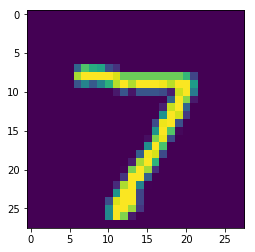

In [259]:
plt.imshow(x_test[0,:,:])

In [ ]:
print(y_out[0])

In [ ]:
del data_train, data_test, model
keras.backend.clear_session()

## 3. Using Keras with tf.data from TFRecord files

**Write a TFRecord file**

Creating your dataset is pretty straightforward. All you need to do is to define your dataset using something like this:

In [344]:
# Helperfunctions to make your feature definition more readable
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _float_feature(array):
    return tf.train.Feature(float_list=tf.train.FloatList(value=array))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def writeTFRecord(filename, image, label):
    """
    filename : string
        TFRecord file name. 
    image : float
         Input numpy array.
    image : int
         Output numpy array.
    """
    
    # create filewriter
    writer = tf.python_io.TFRecordWriter(filename)
    
    for i in range(label.shape[0]):
        
        # Define the features of your tfrecord
        #feature = {'image':  _bytes_feature(tf.compat.as_bytes(image[i].tostring())),
        #           'label':  _int64_feature(int(label[i]))}
        
        feature = {'image':  _float_feature(image[i]),
                   'label':  _int64_feature(int(label[i]))}
        
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        
        # Serialize to string and write to file
        writer.write(example.SerializeToString())
        
    writer.close()

In [345]:
(x_train, y_train),(x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


In [346]:
nClasses = 10
nData_train = x_train.shape[0]
nData_test = x_test.shape[0]
nDimIn = x_train.shape[1]*x_train.shape[2]
input_shape = (x_train.shape[1], x_train.shape[2])

Data should have 1D

In [347]:
x_train_vec = x_train.reshape([nData_train,-1])
x_test_vec = x_test.reshape([nData_test,-1])

In [348]:
file_train = 'mnist_train.tfrecords'
file_test = 'mnist_test.tfrecords'

In [349]:
writeTFRecord(file_train, x_train_vec, y_train)
writeTFRecord(file_test, x_test_vec, y_test)

**Read TFRecord files**

In [350]:
nImages = 0
for record in tf.python_io.tf_record_iterator("mnist_train.tfrecords"):
    example = tf.train.Example()
    example.ParseFromString(record) # calling protocol buffer API

    nImages += 1

print('Number of images', nImages)

Number of images 60000


**Training from the TFRecord files**

Data preprocessing

In [351]:
def parse_function(proto):
    # define your tfrecord again. Remember that you saved your image as a string.
    #features = {'image': tf.FixedLenFeature([], tf.string),
    #            'label': tf.FixedLenFeature([], tf.int64)}
    
    features = {'image': tf.FixedLenFeature([input_shape[0], input_shape[1], 1], tf.float32),
                'label': tf.FixedLenFeature([], tf.int64)}
    
    # Load one example
    parsed_features = tf.parse_single_example(proto, features)
    
    # Turn your saved image string into an array
    #image = tf.decode_raw(parsed_features['image'], tf.float32)
    image = parsed_features['image']
    
    # Normalize
    image = tf.divide(image, 255.0)
    
    # Bring your picture back in shape
    #image = tf.reshape(image, [input_shape[0], input_shape[1], 1])
    
    # Create a one hot array for your labels
    label = tf.one_hot(parsed_features['label'], nClasses)
    
    return image, label

Prepare train and test datasets using tf.data

In [352]:
def create_dataset(filepath, shuffleSize, batchSize):
    
    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepath)
    
    # Maps the preprocessing function. You can set the number of parallel loaders here
    dataset = dataset.map(parse_function, num_parallel_calls=8)
    
    # This dataset will go on forever
    dataset = dataset.repeat()
    
    # Set the number of datapoints you want to load and shuffle 
    dataset = dataset.shuffle(shuffleSize)
    
    # Set the batchsize
    dataset = dataset.batch(batchSize)
    
    # Create an iterator
    iterator = dataset.make_one_shot_iterator()
    
    return iterator

In [353]:
batchSize = 16
dataset_train = create_dataset(filepath='mnist_train.tfrecords', shuffleSize=60000, batchSize=batchSize)
dataset_test = create_dataset(filepath='mnist_test.tfrecords', shuffleSize=10000, batchSize=batchSize)

In [354]:
nEpoch = 1
nStep_train = (int)(x_train.shape[0]/batchSize)
nStep_test = (int)(x_test.shape[0]/batchSize)

In [355]:
model = myModel(inputShape = (input_shape[0], input_shape[1], 1), nClasses = 10)

**Train model**

In [356]:
model.fit(dataset_train, epochs=nEpoch, validation_data=dataset_test, steps_per_epoch=nStep_train, validation_steps=nStep_test)

3750/3750 [==============================] - 123s 33ms/step - loss: 0.1856 - acc: 0.9440 - val_loss: 0.0509 - val_acc: 0.9832


**Prediction**

In [357]:
def parse_function(proto):
    
    #features = {'image': tf.FixedLenFeature([], tf.string)}
    features = {'image': tf.FixedLenFeature([input_shape[0], input_shape[1], 1], tf.float32)}
    
    # Load one example
    parsed_features = tf.parse_single_example(proto, features)
    
    # Turn your saved image string into an array
    #image = tf.decode_raw(parsed_features['image'], tf.float32)
    image = parsed_features['image']
    
    # Normalize
    image = tf.divide(image, 255.0)
    
    # Bring your picture back in shape
    #image = tf.reshape(image, [input_shape[0], input_shape[1], 1])
    
    return image

In [358]:
def create_dataset(filepath, batchSize):
    
    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepath)
    
    # Maps the preprocessing function. You can set the number of parallel loaders here
    dataset = dataset.map(parse_function, num_parallel_calls=8)
    
    # This dataset will go on forever
    dataset = dataset.repeat()
    
    # Set the batchsize
    dataset = dataset.batch(batchSize)
    
    # Create an iterator
    iterator = dataset.make_one_shot_iterator()
    
    return iterator

In [359]:
batchSize = 16
dataset_val = create_dataset(filepath='mnist_test.tfrecords', batchSize=batchSize)

In [360]:
y_out = model.predict(dataset_val, steps=nStep_test, batch_size=batchSize)

In [361]:
print(y_test[0])

7


In [362]:
print(y_out[0])

[1.1474142e-09 1.9271996e-08 5.2487405e-07 1.1401833e-07 2.7804974e-08
 6.8149222e-11 1.5799461e-12 9.9999559e-01 2.9921982e-10 3.6670765e-06]


In [363]:
del dataset_train, dataset_test, model
keras.backend.clear_session()

## 4. Using a pre-made estimator with tf.data from TFRecord files

Data preprocessing

In [ ]:
def myMapFunc_scalar(example):
    feature_def = {'X': tf.FixedLenFeature(nDimIn, tf.float32),
                   'Y': tf.FixedLenFeature(1, tf.int64)}
    features = tf.parse_single_example(example, feature_def)
    norm = tf.constant(255, dtype=tf.float32, shape=(nDimIn,))
    xx = tf.div(features['X'], norm)
    yy = features['Y']
    return {'X': xx}, yy

TF Estimator require an input function

In [ ]:
def myInputFunc_scalar(filename,numData):
    data_temp = tf.data.TFRecordDataset(filename)
    data_temp = data_temp.shuffle(buffer_size=numData).map(myMapFunc_scalar).batch(batchSize).repeat()
    return data_temp

Create an estimator

In [ ]:
feature_columns = [tf.feature_column.numeric_column('X', shape=[784,])]
estimator = tf.estimator.DNNClassifier(
 feature_columns=feature_columns,
 hidden_units=[40, 40],
 optimizer=tf.train.AdamOptimizer(0.001),
 n_classes=10,
)

Training

In [ ]:
estimator.train(input_fn=lambda:myInputFunc_scalar(file_train,nData_train), steps=nStep_train*nEpoch)

Test

In [ ]:
eval_result_1 = estimator.evaluate(input_fn=lambda:myInputFunc_scalar(file_test,nData_test), steps=nStep_test)

In [ ]:
print(eval_result_1)

## 5. Using an estimator from a Keras model with tf.data from TFRecord files

Data preprocessing

In [ ]:
def myMapFunc_onehot(example):
    feature_def = {'X': tf.FixedLenFeature(nDimIn, tf.float32),
                   'Y': tf.FixedLenFeature(1, tf.int64)}
    features = tf.parse_single_example(example, feature_def)
    norm = tf.constant(255, dtype=tf.float32, shape=(nDimIn,))
    xx = tf.div(features['X'], norm)
    yy = tf.reshape(tf.one_hot(features['Y'], nClass, dtype=tf.float32), [-1])
    return xx, yy

Input function for the estimator

In [ ]:
def myInputFunc_onehot(filename,numData):
    data_temp = tf.data.TFRecordDataset(filename)
    data_temp = data_temp.shuffle(buffer_size=numData).map(myMapFunc_onehot).batch(batchSize).repeat()
    return data_temp

Convert a Keras model to an estimator

In [ ]:
model = myModel()
estimator = keras.estimator.model_to_estimator(model)

Training

In [ ]:
estimator.train(input_fn=lambda:myInputFunc_onehot(file_train,nData_train), steps=nStep_train*nEpoch)

Test

In [ ]:
eval_result_2 = estimator.evaluate(input_fn=lambda:myInputFunc_onehot(file_test, nData_test), steps=nStep_test)

In [ ]:
print(eval_result_2)

## 6. Accessing data on google cloud (google storage)

- Before starting the tutorial, install google cloud storage by ```pip install google-cloud-storage```

- [Important] You cannot write or upload a file on google cloud using a VM with the default setting. If you see a permission error (related to 403 POST), go to VM instance details and edit your "Cloud API access scopes" on the bottom from "defalt" to "full access" 

In [ ]:
from google.cloud import storage
client = storage.Client()
bucketname = 'your-bucket-name'
bucket = client.get_bucket(bucketname)

Upload files to 'gs://data-push-wearableband/temp/'

In [ ]:
target_folder = 'sub-folder-name/'

In [ ]:
blob_train = storage.Blob(target_folder+file_train, bucket) # destination
blob_train.upload_from_filename(file_train) # source file
blob_test = storage.Blob(target_folder+file_test, bucket) # destination
blob_test.upload_from_filename(file_test) # source file

Get the list of files in the bucket

In [ ]:
filelist = []
blobs = bucket.list_blobs(prefix=target_folder)
for blob in blobs:
    filelist.append(blob.name)   
print(filelist) 
# Note that 'temp/' is included in the file list

Train a model using the data on the cloud

In [ ]:
fullpath_train = 'gs://'+bucketname+'/'+target_folder+file_train
fullpath_test = 'gs://'+bucketname+'/'+target_folder+file_test
print(fullpath_train)
print(fullpath_test)

Convert a Keras model to an estimator

Training

In [ ]:
estimator.train(input_fn=lambda:myInputFunc_onehot(file_train, nData_train), steps=nStep_train*nEpoch)

Test

In [ ]:
eval_result_3 = estimator.evaluate(input_fn=lambda:myInputFunc_onehot(fullpath_test, nData_test), steps=nStep_test)

In [ ]:
print(eval_result_3)